# 🧠 Medical Imaging Final Project:
# Brain Tumor Classification: VGG16, EfficientNet, Resnet101, XCeption
### MIC — Spring 2025  
### **Team 1**

**Team Members:**  
- Lam Nguyen  
- Faramarz Aboutalebi  

---

This project focuses on applying deep learning techniques for tumor classification in MRI brain scans using convolutional neural networks and interpretability tools. The notebook includes data preprocessing, model training with transfer learning, performance evaluation, visualization techniques (Grad-CAM, ROC, PR curves), and several diagnostic tools.


# Step 1: Environment Setup and Library Imports

In [ ]:
%pip install -r requirements.txt

In [18]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageEnhance
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization,Input,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Check if GPU is available and show basic info
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("🔋 GPU detected — accelerated training enabled.")
    for device in gpu_devices:
        print("Device in use:", device)
else:
    print("⚙️ Training will proceed on CPU — no GPU found.")

# Print Dataset
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

🔋 GPU detected — accelerated training enabled.
Device in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device in use: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
dataset/brain.tar.gz
dataset/Testing/glioma/Te-glTr_0000.jpg
dataset/Testing/glioma/Te-glTr_0001.jpg
dataset/Testing/glioma/Te-glTr_0002.jpg
dataset/Testing/glioma/Te-glTr_0003.jpg
dataset/Testing/glioma/Te-glTr_0004.jpg
dataset/Testing/glioma/Te-glTr_0005.jpg
dataset/Testing/glioma/Te-glTr_0006.jpg
dataset/Testing/glioma/Te-glTr_0007.jpg
dataset/Testing/glioma/Te-glTr_0008.jpg
dataset/Testing/glioma/Te-glTr_0009.jpg
dataset/Testing/glioma/Te-gl_0010.jpg
dataset/Testing/glioma/Te-gl_0011.jpg
dataset/Testing/glioma/Te-gl_0012.jpg
dataset/Testing/glioma/Te-gl_0013.jpg
dataset/Testing/glioma/Te-gl_0014.jpg
dataset/Testing/glioma/Te-gl_0015.jpg
dataset/Testing/glioma/Te-gl_0016.jpg
dataset/Testing/glioma/Te-gl_0018.jpg
dataset/Testing/glioma/Te-gl_0019.jpg
dataset/Testing/glioma/Te-gl_0

In [59]:
# Training Parameters
batch_size = 8
epochs = 15
image_size = 150
training_split = 0.1
verbose=1

# Step 2: Dataset Path Setup and Class Mapping

In [3]:
# Configure dataset paths relative to project location
project_root = os.getcwd()
train_path = os.path.join(project_root, "dataset", "Training")
test_path = os.path.join(project_root, "dataset", "Testing")


X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)



100%|██████████| 300/300 [00:00<00:00, 2170.19it/s]


# Step 3: Data Visualization

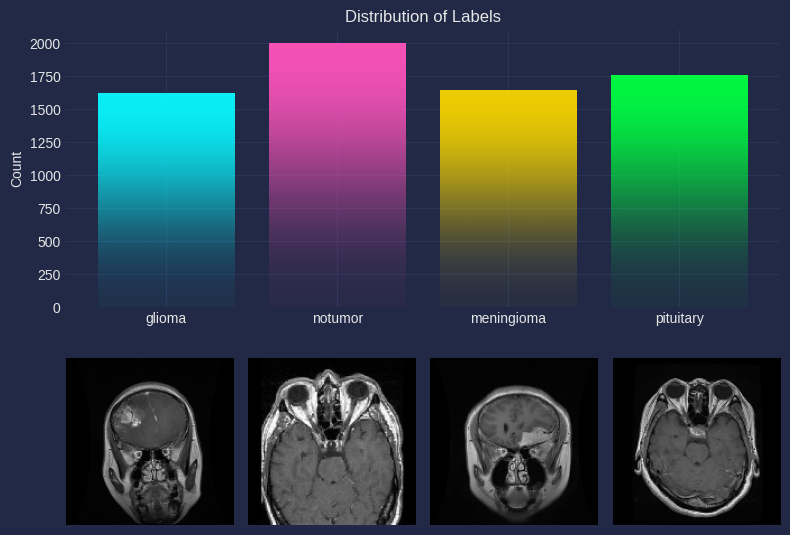

In [4]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Random Sample Image and Preview

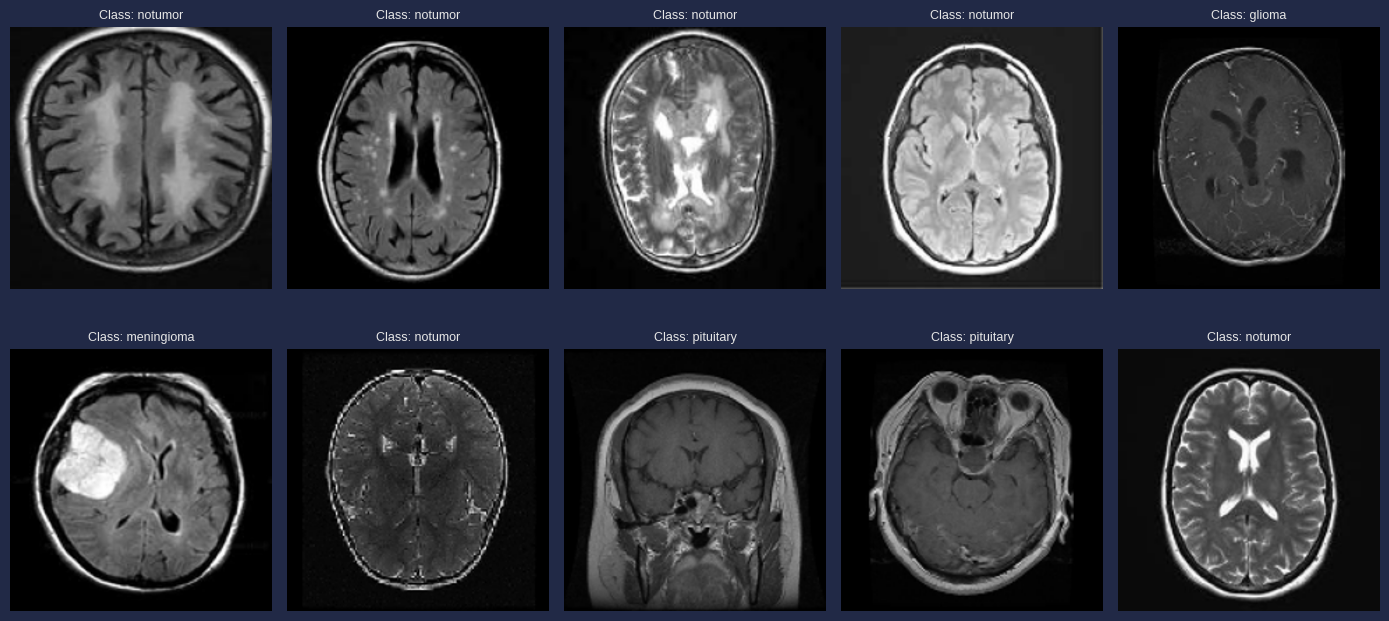

In [5]:
# Preview a few training images with labels
def preview_samples(images, labels, count=10):
    selected = random.sample(range(len(images)), count)
    fig, axarr = plt.subplots(2, 5, figsize=(14, 7))
    axarr = axarr.flatten()

    for i, idx in enumerate(selected):
        # Convert NumPy array to PIL Image (no .open() needed)
        img = Image.fromarray(images[idx]).resize((224, 224)) # Use fromarray() instead of open
        #img = Image.open(images[idx]).resize((224, 224))
        axarr[i].imshow(img)
        axarr[i].axis('off')
        axarr[i].set_title(f"Class: {labels[idx]}", fontsize=9)

    plt.tight_layout()
    plt.show()

# Display random examples from training set
preview_samples(X_train, y_train)

# Step 4: Preprocessing Functions (Augmentation, Normalization)

### Dataset Split and Train

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One Hot Encoding Labels

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Step 05: Compile and Train VGG16

In [8]:
# Load VGG16 pretrained on ImageNet (without top layers)
vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)  # Ensure `image_size` is defined (e.g., 224)
)

vgg16.trainable = False


# Build custom model on top of VGG16

model = vgg16.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(128, activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=vgg16.input, outputs=model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1745272103.477304   15031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1745272103.478698   15031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22321 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Get GPU Usage:
!nvidia-smi

Mon Apr 21 17:48:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   31C    P2            111W /  350W |   22602MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/vgg16_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=training_split, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=training_split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tensorboard, checkpoint, reduce_lr],
    verbose=verbose
)


Epoch 1/15


I0000 00:00:1745272136.771504   15195 service.cc:148] XLA service 0x74c0b8020160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745272136.771523   15195 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1745272136.771527   15195 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-21 17:48:56.783829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745272136.890142   15195 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1745272137.302165   15195 buffer_comparator.cc:157] Difference at 16: 0.731763, expected 8.13301
E0000 00:00:1745272137.302189   15195 buffer_comparator.cc:157] Difference at 17: 0.656412, expected 7.893
E0000 00:00:1745272137.302191   15195 buffer_comparator.cc:157] Difference at 18: 0.41

 20/711 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4162 - loss: 7.3565

I0000 00:00:1745272138.087391   15195 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6693 - loss: 2.1630
Epoch 1: val_accuracy improved from -inf to 0.86867, saving model to checkpoints/vgg16_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6694 - loss: 2.1616 - val_accuracy: 0.8687 - val_loss: 0.3808 - learning_rate: 0.0010
Epoch 2/15
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8360 - loss: 0.4505
Epoch 2: val_accuracy did not improve from 0.86867
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8360 - loss: 0.4505 - val_accuracy: 0.8623 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8687 - loss: 0.3444
Epoch 3: val_accuracy improved from 0.86867 to 0.87025, saving model to checkpoints/vgg16_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8687 - loss: 0.3445 - val_accuracy: 0.8703 - val_loss: 0.3506 - learning_rate: 0.0010
Epoch 4/15
707/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0

In [12]:
model.save('checkpoints/vgg16_checkpoint.keras')

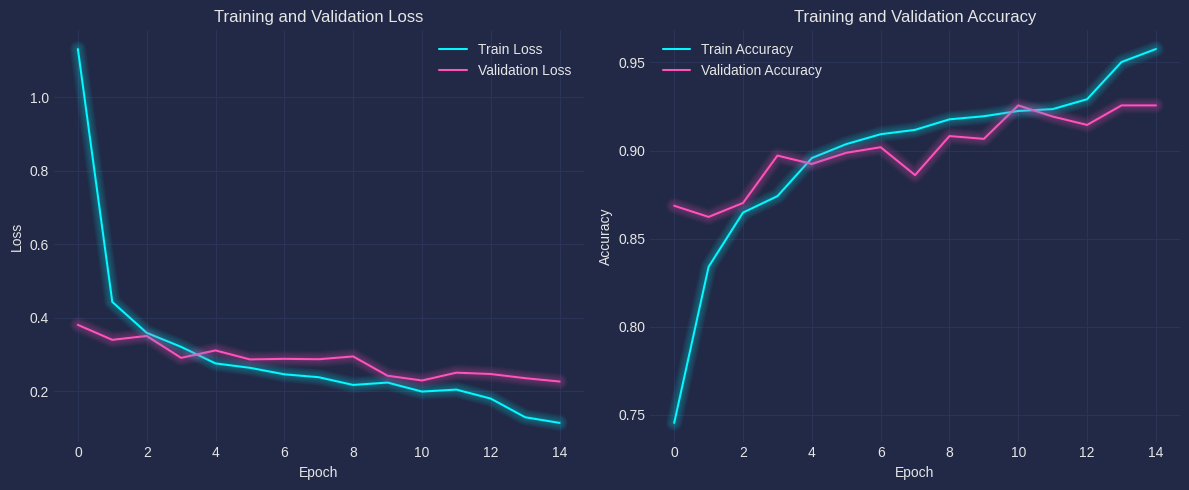

In [13]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

E0000 00:00:1745272286.054190   15192 buffer_comparator.cc:157] Difference at 16: 0, expected 8.13561
E0000 00:00:1745272286.054213   15192 buffer_comparator.cc:157] Difference at 17: 0, expected 8.2063
E0000 00:00:1745272286.054215   15192 buffer_comparator.cc:157] Difference at 18: 0, expected 7.85227
E0000 00:00:1745272286.054216   15192 buffer_comparator.cc:157] Difference at 19: 1, expected 8.13284
E0000 00:00:1745272286.054217   15192 buffer_comparator.cc:157] Difference at 20: 0, expected 7.94466
E0000 00:00:1745272286.054218   15192 buffer_comparator.cc:157] Difference at 21: 1, expected 8.06869
E0000 00:00:1745272286.054219   15192 buffer_comparator.cc:157] Difference at 22: 0, expected 7.90552
E0000 00:00:1745272286.054220   15192 buffer_comparator.cc:157] Difference at 23: 0, expected 8.3207
E0000 00:00:1745272286.054221   15192 buffer_comparator.cc:157] Difference at 24: 0, expected 8.38194
E0000 00:00:1745272286.054222   15192 buffer_comparator.cc:157] Difference at 25: 0,

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

E0000 00:00:1745272287.996389   15190 buffer_comparator.cc:157] Difference at 172: 8.60204, expected 7.58539
E0000 00:00:1745272287.996414   15190 buffer_comparator.cc:157] Difference at 195: 9.56963, expected 8.30659
E0000 00:00:1745272287.996416   15190 buffer_comparator.cc:157] Difference at 231: 9.26401, expected 8.16522
E0000 00:00:1745272287.996418   15190 buffer_comparator.cc:157] Difference at 237: 7.23513, expected 8.15784
E0000 00:00:1745272287.996419   15190 buffer_comparator.cc:157] Difference at 282: 9.51006, expected 8.08205
E0000 00:00:1745272287.996420   15190 buffer_comparator.cc:157] Difference at 293: 9.12199, expected 8.04249
E0000 00:00:1745272287.996421   15190 buffer_comparator.cc:157] Difference at 298: 8.77662, expected 7.50433
E0000 00:00:1745272287.996422   15190 buffer_comparator.cc:157] Difference at 300: 8.91019, expected 7.55849
E0000 00:00:1745272287.996423   15190 buffer_comparator.cc:157] Difference at 301: 8.83602, expected 7.79232
E0000 00:00:1745272

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
Confusion Matrix:
[[ 53   1  64  52]
 [  0 161  11  31]
 [  0   3 126  45]
 [  0   4   9 143]]


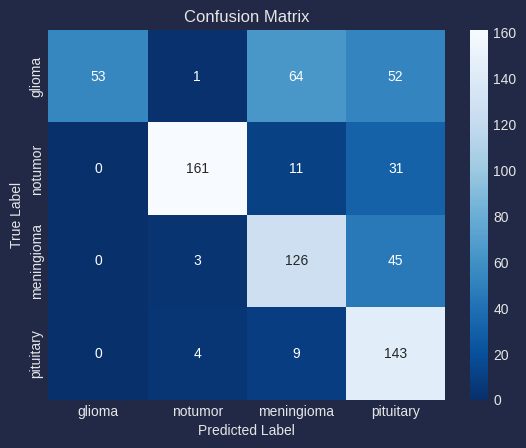

In [14]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


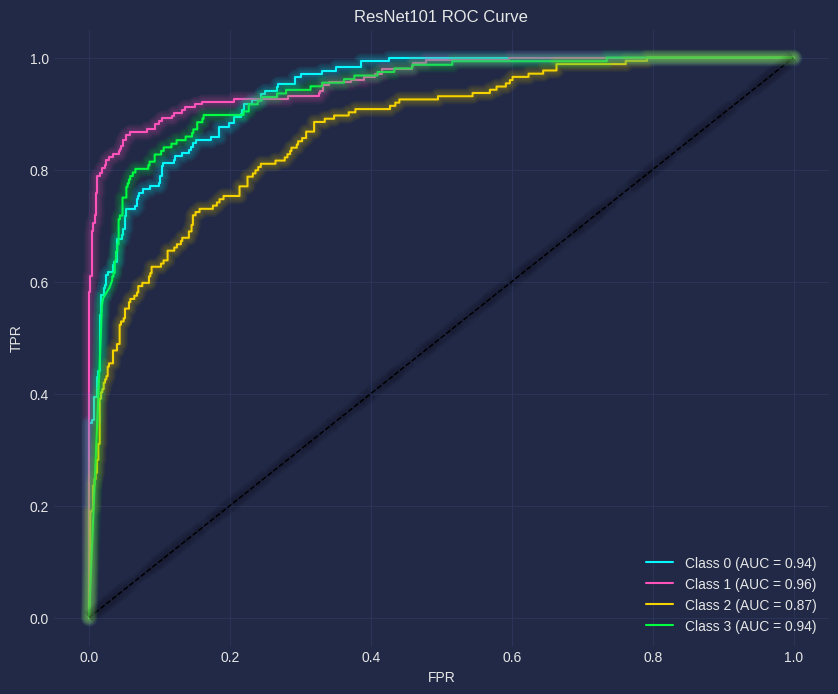

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ResNet101 ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [15]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.31      0.48       170
           1       0.95      0.79      0.87       203
           2       0.60      0.72      0.66       174
           3       0.53      0.92      0.67       156

    accuracy                           0.69       703
   macro avg       0.77      0.69      0.67       703
weighted avg       0.78      0.69      0.68       703



### Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


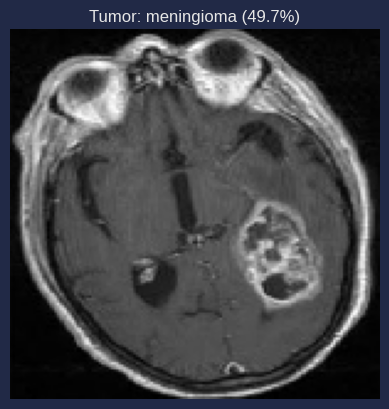

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


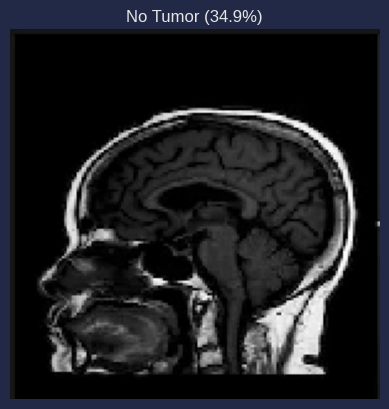

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


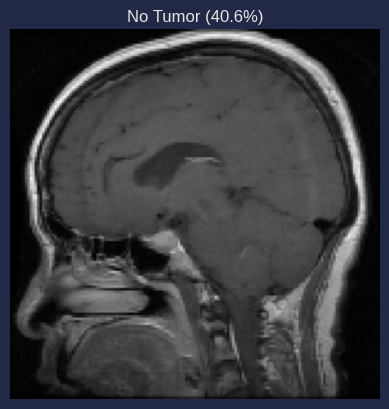

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


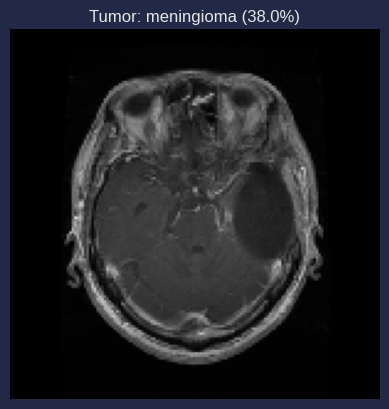

In [20]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/vgg16_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Precision-Recall Curves

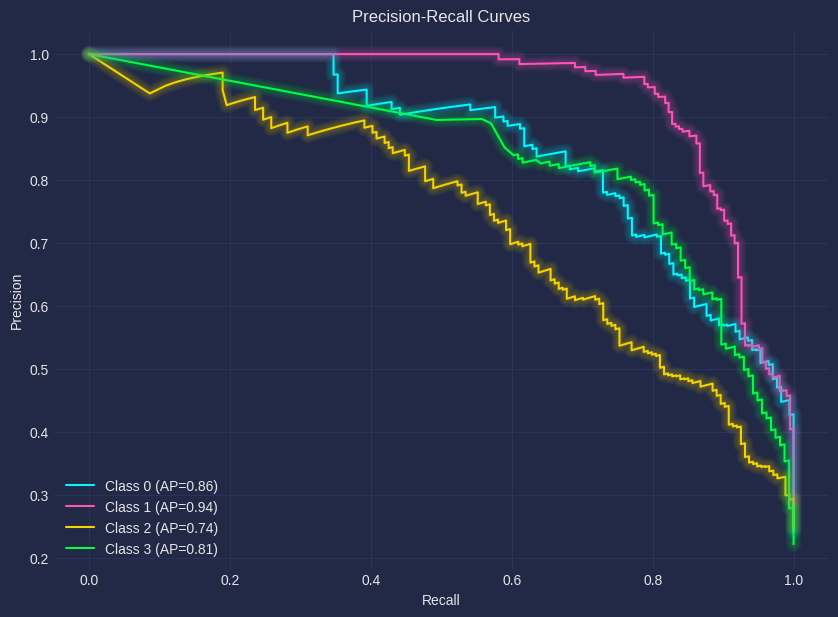

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()


### Upload and Detect Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


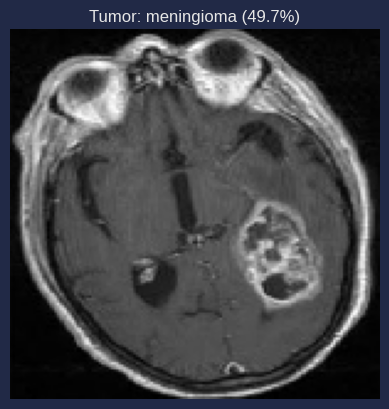

In [22]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()


### Export to CSV (Predictions + Ground Truth)

In [23]:
import pandas as pd

# Export test results to CSV
pred_labels = [tumor_types[i] for i in y_pred]
true_labels = [tumor_types[i] for i in y_test]

df_results = pd.DataFrame({
    "Image": test_images,
    "True Label": true_labels,
    "Predicted Label": pred_labels
})
df_results.to_csv("prediction_results.csv", index=False)
print("✅ Results saved to prediction_results.csv")

TypeError: only integer scalar arrays can be converted to a scalar index

### Top-K Accuracy Visualization

In [24]:
# Calculate top-k accuracy for top-1, top-2, top-3
def compute_top_k_accuracies(probs, true_labels, k_list=[1, 2, 3]):
    results = {}
    for k in k_list:
        top_k_preds = np.argsort(probs, axis=1)[:, -k:]
        correct = sum([true_labels[i] in top_k_preds[i] for i in range(len(true_labels))])
        results[k] = correct / len(true_labels)
    return results

topk_scores = compute_top_k_accuracies(y_prob, y_test)

colors = ["C0", "C1", "C2", "C3"]

# Plot top-k results
plt.figure(figsize=(6, 4))
bars=plt.bar([f"Top-{k}" for k in topk_scores], topk_scores.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.ylim(0, 1)
plt.title("Top-k Prediction Accuracy")
plt.ylabel("Accuracy")
plt.grid(True, axis='y')
plt.show()


ValueError: operands could not be broadcast together with shapes (2,) (4,) 

### Confidence Plot Cell

In [ ]:
# Confidence for each test prediction
confidences = np.max(y_prob, axis=1)

plt.figure(figsize=(10, 4))
plt.bar(range(len(confidences)), confidences, color='pink')
plt.title("Prediction Confidence per Sample")
plt.xlabel("Test Sample Index")
plt.ylabel("Confidence Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
mplcyberpunk.make_lines_glow()
plt.show()

### Misclassified Images Viewer

In [ ]:
# Show incorrect predictions with actual and predicted labels
wrong_idxs = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
print(f"❌ Misclassified Samples: {len(wrong_idxs)}")

for idx in wrong_idxs[:5]:  # show first 5 mistakes
    img = Image.open(test_images[idx])
    plt.imshow(img)
    plt.title(f"True: {tumor_types[y_test[idx]]}, Pred: {tumor_types[y_pred[idx]]}")
    plt.axis('off')
    plt.show()

In [25]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

# Step 06: Compile and Train EfficientNet

In [26]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
#Get Model Size
!nvidia-smi

Mon Apr 21 18:04:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 30%   30C    P8             15W /  350W |   22646MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/efficientnet_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split = training_split, epochs = epochs, verbose = verbose,
                    batch_size = batch_size, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


2025-04-21 17:59:36.012028: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511_0', 8 bytes spill stores, 8 bytes spill loads

2025-04-21 17:59:36.321790: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388_0', 24 bytes spill stores, 24 bytes spill loads

2025-04-21 17:59:36.497908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 232 bytes spill stores, 232 bytes spill loads

2025-04-21 17:59:36.525007: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388', 4 bytes spill stores, 4 bytes spill loads

2025-04-21 17:59:36.591464: I external/local_xla/xla/s

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8521 - loss: 0.4294

2025-04-21 17:59:58.066264: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388_0', 24 bytes spill stores, 24 bytes spill loads

2025-04-21 17:59:58.137864: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 8 bytes spill stores, 8 bytes spill loads

2025-04-21 17:59:58.347943: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 108 bytes spill stores, 108 bytes spill loads

E0000 00:00:1745272798.492081   15192 buffer_comparator.cc:157] Difference at 23: 0, expected 0.139466
E0000 00:00:1745272798.492106   15192 buffer_comparator.cc:157] Difference at 39: 0, expected 0.132154
E0000 00:00:1745272798.492108   15192 buffer_comparator.cc:157] Difference at 41: 0,

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8524 - loss: 0.4287

2025-04-21 18:00:12.796552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2084', 196 bytes spill stores, 196 bytes spill loads

E0000 00:00:1745272812.797920   15193 buffer_comparator.cc:157] Difference at 39: 472.156, expected 528.569
E0000 00:00:1745272812.797949   15193 buffer_comparator.cc:157] Difference at 55: 458.375, expected 533.637
E0000 00:00:1745272812.797950   15193 buffer_comparator.cc:157] Difference at 64: 23.5269, expected 512.719
E0000 00:00:1745272812.797952   15193 buffer_comparator.cc:157] Difference at 65: 26.7269, expected 529.412
E0000 00:00:1745272812.797953   15193 buffer_comparator.cc:157] Difference at 66: 21.7279, expected 521.502
E0000 00:00:1745272812.797954   15193 buffer_comparator.cc:157] Difference at 67: 20.9737, expected 526.731
E0000 00:00:1745272812.797955   15193 buffer_comparator.cc:157] Difference at 68: 22.7224, expected 512.801
E0000 0


Epoch 1: val_accuracy improved from -inf to 0.91297, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.8527 - loss: 0.4280 - val_accuracy: 0.9130 - val_loss: 0.2542 - learning_rate: 0.0010
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9476 - loss: 0.1451
Epoch 2: val_accuracy did not improve from 0.91297
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9476 - loss: 0.1451 - val_accuracy: 0.9098 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 3/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9726 - loss: 0.0818
Epoch 3: val_accuracy improved from 0.91297 to 0.96677, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9726 - loss: 0.0819 - val_accuracy: 0.9668 - val_loss: 0.0948 - learning_rate: 0.0010
Epoch 4/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9853 - loss: 0.0505
Epoch 4: val_accuracy did not improve from 0.96677
178/178 ━━━━━━━━━━━━━━━━━

In [30]:
model.save('checkpoints/efficientnet_checkpoint.keras')

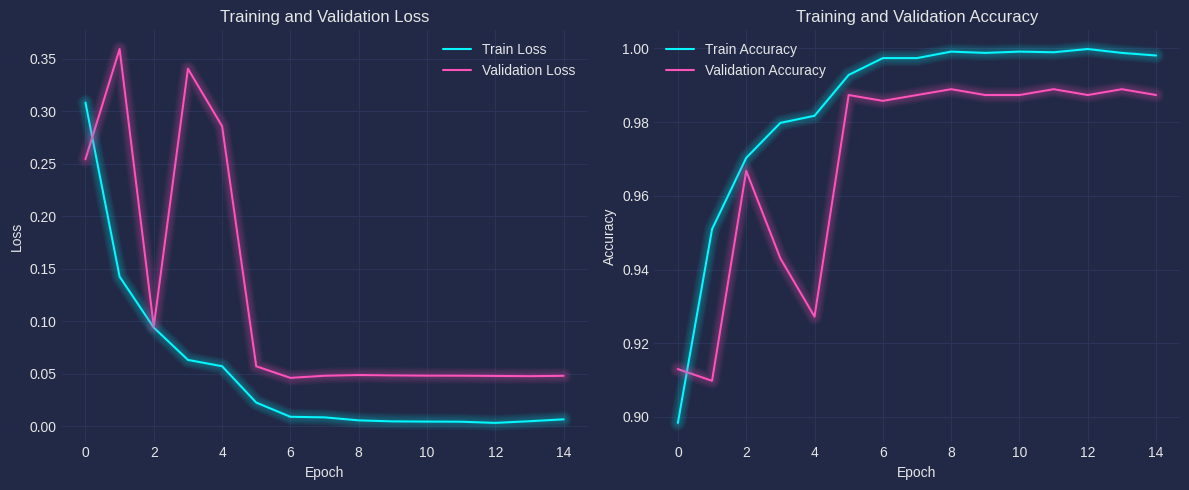

In [31]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()


### Evaluation

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-04-21 18:01:45.209078: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2039', 4 bytes spill stores, 4 bytes spill loads

2025-04-21 18:01:45.261923: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2039', 184 bytes spill stores, 184 bytes spill loads

2025-04-21 18:01:45.313676: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2032', 216 bytes spill stores, 216 bytes spill loads

E0000 00:00:1745272905.315011   15192 buffer_comparator.cc:157] Difference at 16: 0, expected 12.8751
E0000 00:00:1745272905.315031   15192 buffer_comparator.cc:157] Difference at 17: 1, expected 13.1966
E0000 00:00:1745272905.315032   15192 buffer_comparator.cc:157] Difference at 18: 0, expe

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step
Confusion Matrix:
[[170   0   0   0]
 [  0 203   0   0]
 [  5   0 168   1]
 [  0   0   2 154]]


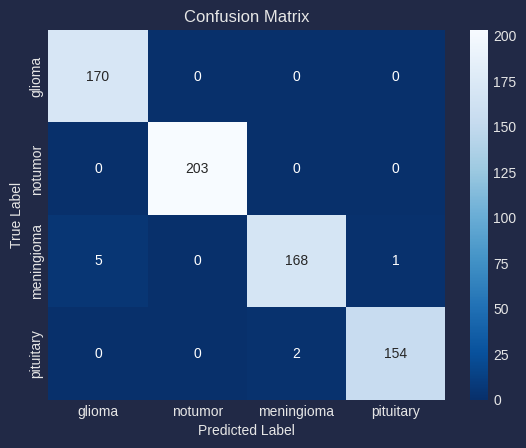

In [32]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [33]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       170
           1       1.00      1.00      1.00       203
           2       0.99      0.97      0.98       174
           3       0.99      0.99      0.99       156

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



### ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


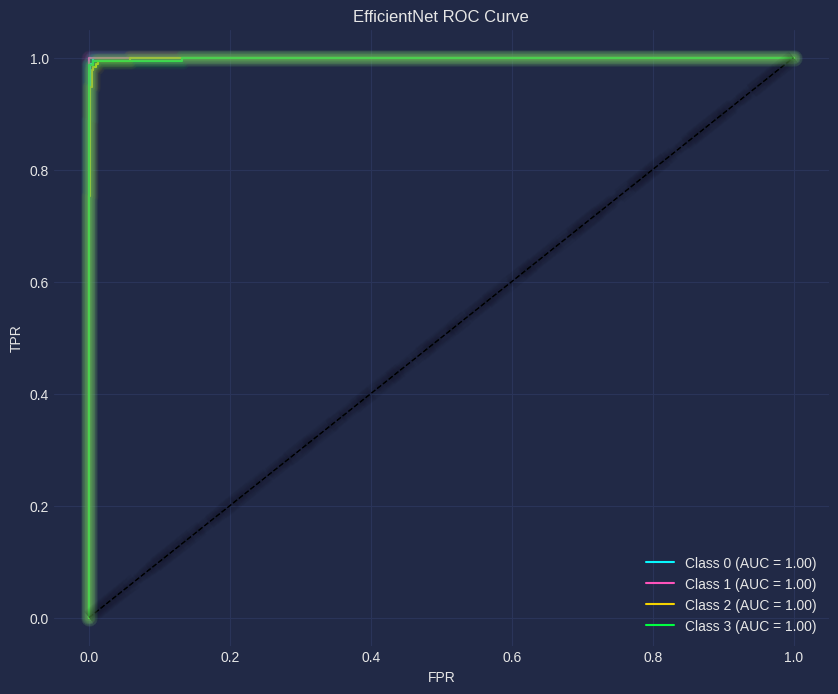

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("EfficientNet ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Prediction

E0000 00:00:1745273122.922796   15190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745273123.028396   15190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745273123.187306   15190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745273123.292857   15190 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


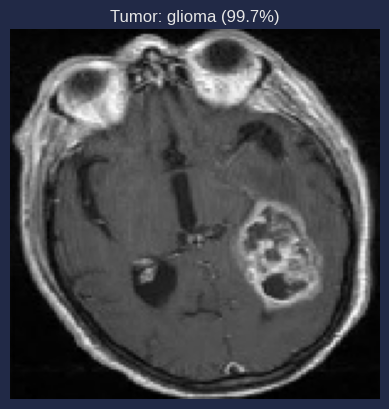

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


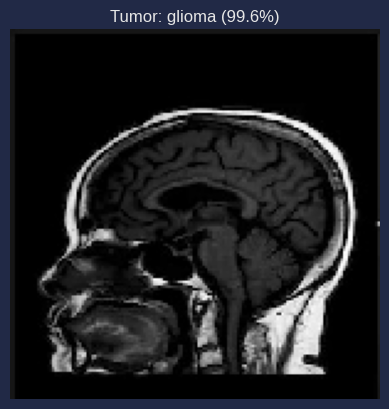

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


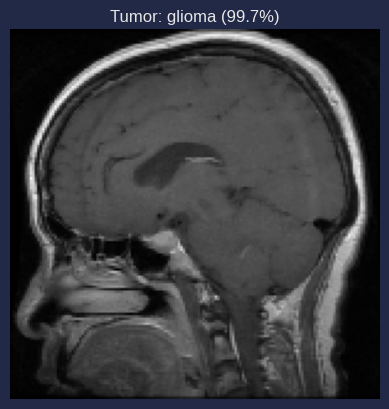

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


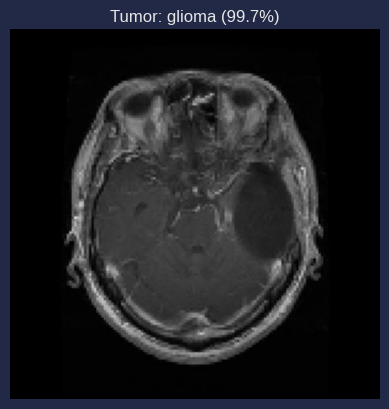

In [37]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/efficientnet_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Precision Recall Curves

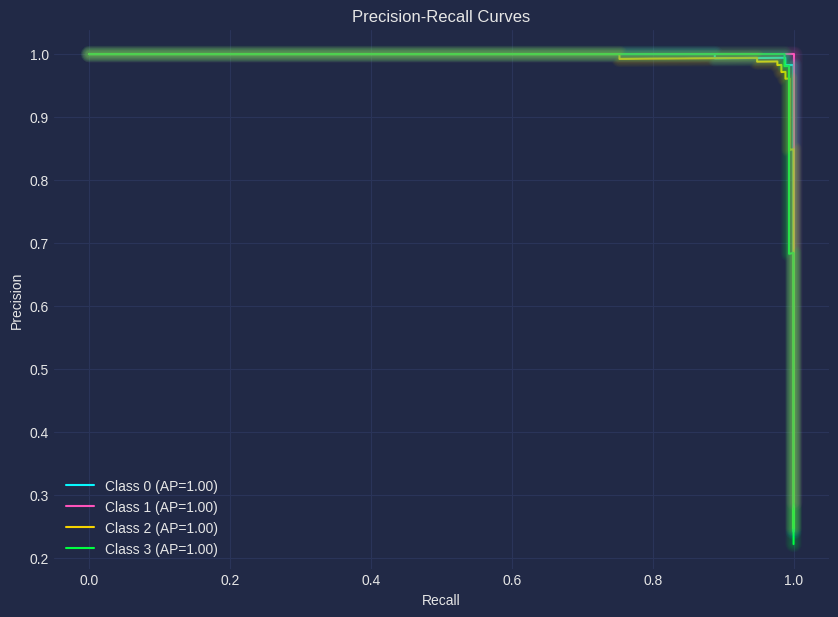

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [42]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()


# Step 07: Compile and Train ResNet101

In [43]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 42,666,372 (162.76 MB)

 Trainable params: 42,561,028 (162.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [45]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/resnet101_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [46]:
history = model.fit(X_train,y_train,validation_split=training_split, epochs =epochs, verbose=1, batch_size=batch_size,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


E0000 00:00:1745273528.421292   15195 buffer_comparator.cc:157] Difference at 64: 0.102557, expected 10.5723
E0000 00:00:1745273528.421317   15195 buffer_comparator.cc:157] Difference at 65: 0.0661242, expected 11.7115
E0000 00:00:1745273528.421319   15195 buffer_comparator.cc:157] Difference at 66: 0.0373106, expected 11.7171
E0000 00:00:1745273528.421320   15195 buffer_comparator.cc:157] Difference at 67: 0.0916749, expected 10.6184
E0000 00:00:1745273528.421321   15195 buffer_comparator.cc:157] Difference at 68: 0.0357255, expected 25.3853
E0000 00:00:1745273528.421322   15195 buffer_comparator.cc:157] Difference at 69: 0.0678724, expected 28.8581
E0000 00:00:1745273528.421323   15195 buffer_comparator.cc:157] Difference at 70: 0.0562706, expected 27.9974
E0000 00:00:1745273528.421324   15195 buffer_comparator.cc:157] Difference at 71: 0.0138392, expected 25.6705
E0000 00:00:1745273528.421325   15195 buffer_comparator.cc:157] Difference at 72: 0.0764608, expected 28.73
E0000 00:00:1

710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6394 - loss: 1.0866

E0000 00:00:1745273573.998061   15196 buffer_comparator.cc:157] Difference at 24: 18.3238, expected 20.9324
2025-04-21 18:12:53.998090: E external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:987] Results do not match the reference. This is likely a bug/unexpected loss of precision.
E0000 00:00:1745273573.998467   15196 buffer_comparator.cc:157] Difference at 0: 17.8801, expected 20.2262
E0000 00:00:1745273573.998471   15196 buffer_comparator.cc:157] Difference at 2: 22.6005, expected 19.8645
E0000 00:00:1745273573.998472   15196 buffer_comparator.cc:157] Difference at 4: 18.5121, expected 20.7578
E0000 00:00:1745273573.998473   15196 buffer_comparator.cc:157] Difference at 8: 18.4681, expected 21.0639
E0000 00:00:1745273573.998474   15196 buffer_comparator.cc:157] Difference at 12: 18.0643, expected 20.5782
E0000 00:00:1745273573.998475   15196 buffer_comparator.cc:157] Difference at 16: 17.3146, expected 20.0473
E0000 00:00:1745273573.998476   15196 buffer_comparator


Epoch 1: val_accuracy improved from -inf to 0.76899, saving model to checkpoints/resnet101_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.6396 - loss: 1.0859 - val_accuracy: 0.7690 - val_loss: 0.6521 - learning_rate: 0.0010
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8313 - loss: 0.4864
Epoch 2: val_accuracy did not improve from 0.76899
711/711 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.8313 - loss: 0.4863 - val_accuracy: 0.4415 - val_loss: 3.2002 - learning_rate: 0.0010
Epoch 3/15
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8787 - loss: 0.3197
Epoch 3: val_accuracy improved from 0.76899 to 0.83386, saving model to checkpoints/resnet101_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.8788 - loss: 0.3197 - val_accuracy: 0.8339 - val_loss: 0.4842 - learning_rate: 0.0010
Epoch 4/15
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9284 - loss: 0.2053
Epoch 4: val_accuracy did not improve f

In [ ]:
# Save Model
model.save('checkpoints/resnet101_checkpoint.keras')

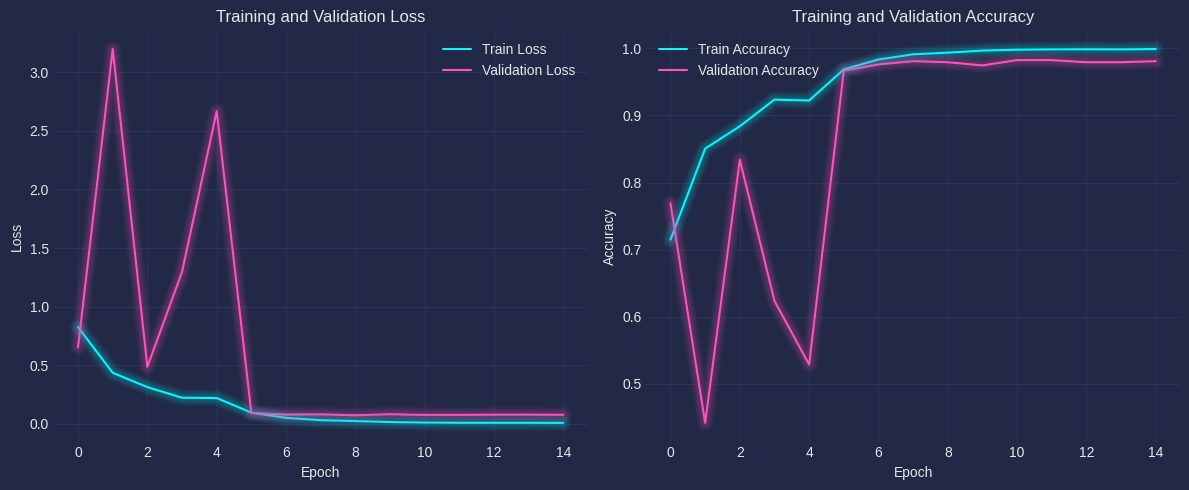

In [48]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

2025-04-21 18:23:00.213999: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3276', 192 bytes spill stores, 192 bytes spill loads

E0000 00:00:1745274180.215524   15190 buffer_comparator.cc:157] Difference at 36: 18.0921, expected 20.4329
E0000 00:00:1745274180.215543   15190 buffer_comparator.cc:157] Difference at 64: 0, expected 21.0351
E0000 00:00:1745274180.215545   15190 buffer_comparator.cc:157] Difference at 65: 3, expected 21.023
E0000 00:00:1745274180.215546   15190 buffer_comparator.cc:157] Difference at 66: 0, expected 20.7641
E0000 00:00:1745274180.215547   15190 buffer_comparator.cc:157] Difference at 67: 5, expected 20.8296
E0000 00:00:1745274180.215548   15190 buffer_comparator.cc:157] Difference at 68: 1, expected 21.1176
E0000 00:00:1745274180.215548   15190 buffer_comparator.cc:157] Difference at 69: 1, expected 20.8684
E0000 00:00:1745274180.215549   15190 buffer

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

2025-04-21 18:23:03.327926: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3276', 176 bytes spill stores, 176 bytes spill loads

E0000 00:00:1745274183.329208   15190 buffer_comparator.cc:157] Difference at 52: 18.537, expected 20.8719
E0000 00:00:1745274183.329226   15190 buffer_comparator.cc:157] Difference at 64: 5, expected 21.1596
E0000 00:00:1745274183.329228   15190 buffer_comparator.cc:157] Difference at 65: 0, expected 20.9341
E0000 00:00:1745274183.329230   15190 buffer_comparator.cc:157] Difference at 66: 2, expected 21.019
E0000 00:00:1745274183.329232   15190 buffer_comparator.cc:157] Difference at 67: 1, expected 20.3573
E0000 00:00:1745274183.329233   15190 buffer_comparator.cc:157] Difference at 68: 1, expected 21.4978
E0000 00:00:1745274183.329235   15190 buffer_comparator.cc:157] Difference at 69: 3, expected 20.7887
E0000 00:00:1745274183.329236   15190 buffer_

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step
Confusion Matrix:
[[164   0   5   1]
 [  0 203   0   0]
 [  0   1 171   2]
 [  0   3   4 149]]


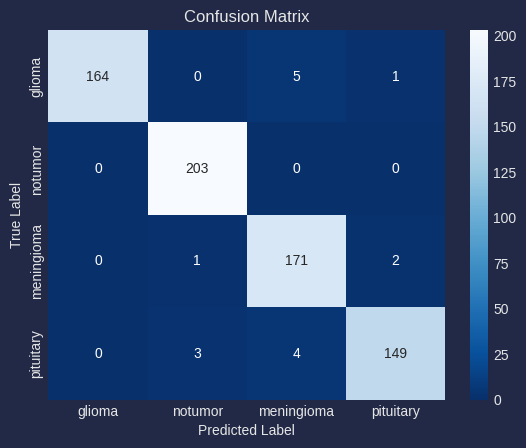

In [49]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 
conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)


heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


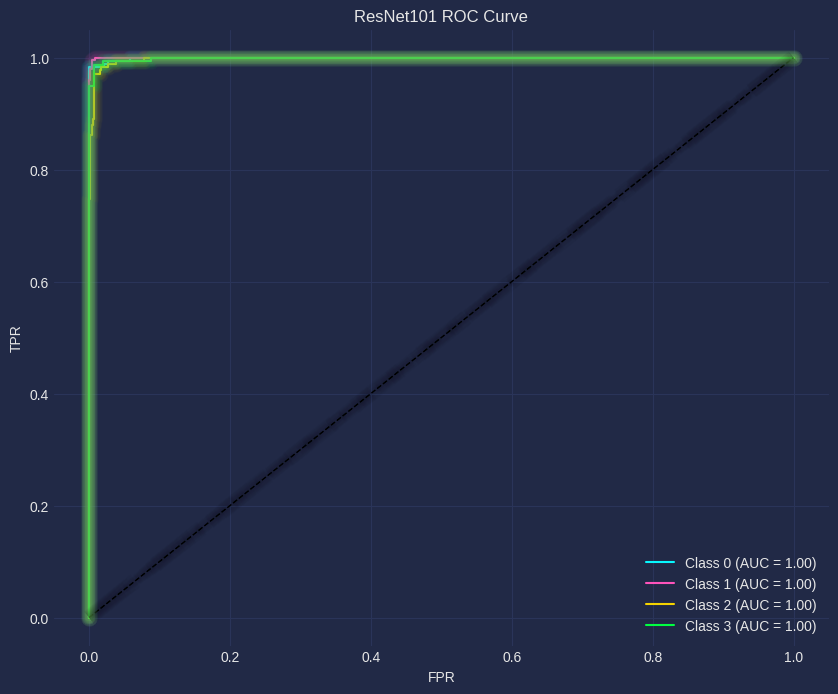

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ResNet101 ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [51]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       170
           1       0.98      1.00      0.99       203
           2       0.95      0.98      0.97       174
           3       0.98      0.96      0.97       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


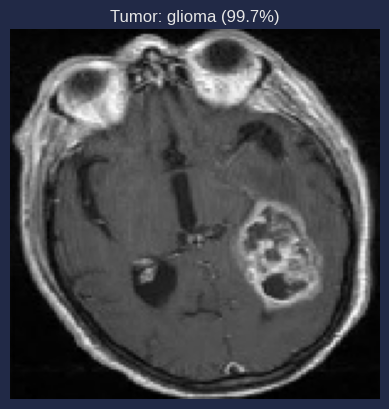

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


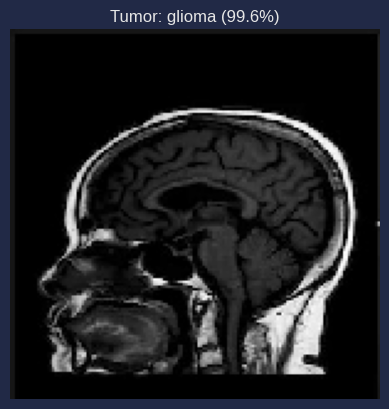

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


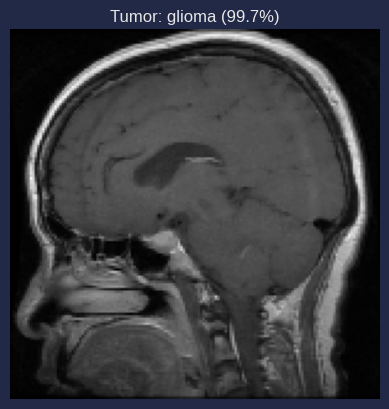

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


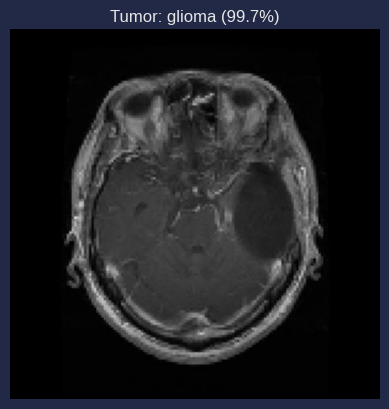

In [52]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/efficientnet_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Precision Recall Curves 

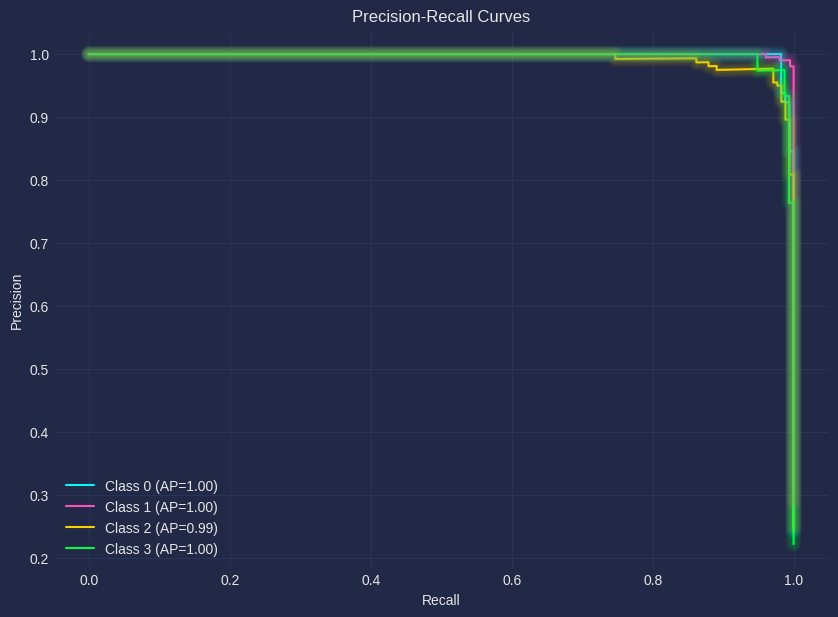

In [53]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [54]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

# Step 08: Compile and Train XCeption

In [55]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 24,014,892 (91.61 MB)

 Trainable params: 23,960,364 (91.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [57]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/xception_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [60]:
history = model.fit(X_train,y_train,validation_split=training_split, epochs =epochs, verbose=verbose, batch_size=batch_size,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


2025-04-21 18:26:59.139146: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7642_0', 28 bytes spill stores, 28 bytes spill loads

E0000 00:00:1745274419.195959   15190 buffer_comparator.cc:157] Difference at 16: -0.708511, expected 0.120524
E0000 00:00:1745274419.195981   15190 buffer_comparator.cc:157] Difference at 17: -0.505891, expected 0.0688511
E0000 00:00:1745274419.195983   15190 buffer_comparator.cc:157] Difference at 18: -0.466613, expected 0.0934863
E0000 00:00:1745274419.195985   15190 buffer_comparator.cc:157] Difference at 19: -0.739767, expected 0.093652
E0000 00:00:1745274419.195986   15190 buffer_comparator.cc:157] Difference at 21: -0.123408, expected 0.0932436
E0000 00:00:1745274419.195987   15190 buffer_comparator.cc:157] Difference at 22: -0.893201, expected 0.0895838
E0000 00:00:1745274419.195988   15190 buffer_comparator.cc:157] Difference at 23: -0.144471, 

710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7218 - loss: 0.7657
Epoch 1: val_accuracy improved from -inf to 0.72152, saving model to checkpoints/xception_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.7221 - loss: 0.7652 - val_accuracy: 0.7215 - val_loss: 0.9059 - learning_rate: 0.0010
Epoch 2/15
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9006 - loss: 0.3043
Epoch 2: val_accuracy improved from 0.72152 to 0.90190, saving model to checkpoints/xception_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9007 - loss: 0.3042 - val_accuracy: 0.9019 - val_loss: 0.2644 - learning_rate: 0.0010
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9364 - loss: 0.1880
Epoch 3: val_accuracy improved from 0.90190 to 0.96044, saving model to checkpoints/xception_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9364 - loss: 0.1880 - val_accuracy: 0.9604 - val_loss: 0.1333 - learning_rate: 0

In [61]:
model.save('checkpoints/xception_checkpoint.keras')

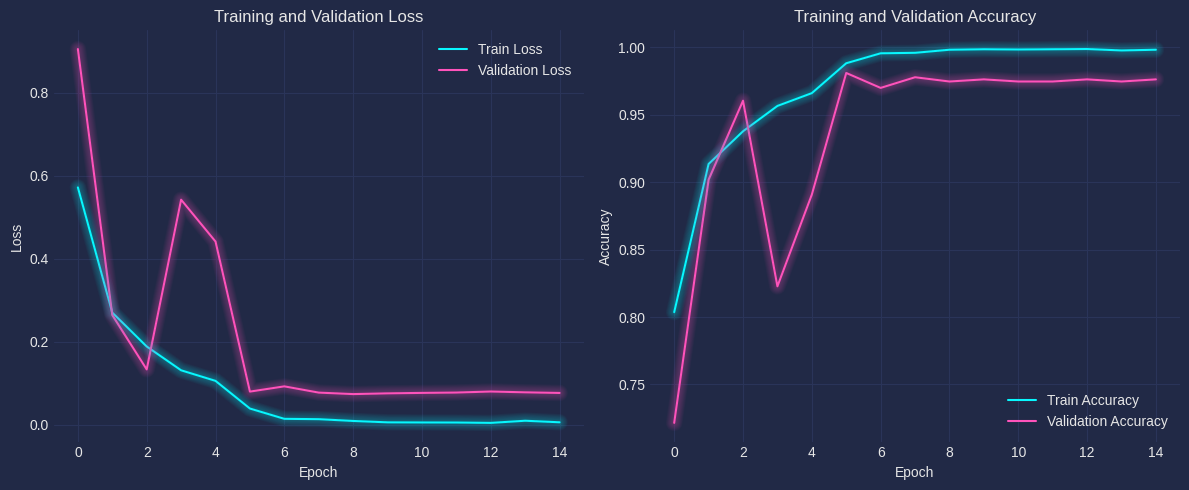

In [62]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

2025-04-21 18:31:57.908060: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014_0', 76 bytes spill stores, 116 bytes spill loads

2025-04-21 18:31:58.001813: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 200 bytes spill stores, 200 bytes spill loads

2025-04-21 18:31:58.004326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 144 bytes spill stores, 388 bytes spill loads

E0000 00:00:1745274718.005929   15195 buffer_comparator.cc:157] Difference at 16: 0, expected 20.4175
E0000 00:00:1745274718.005948   15195 buffer_comparator.cc:157] Difference at 17: 0, expected 20.5104
E0000 00:00:1745274718.005952   15195 buffer_comparator.cc:157] Difference at 18: 0,

21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2025-04-21 18:32:01.481327: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 4 bytes spill stores, 4 bytes spill loads

2025-04-21 18:32:01.669680: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 188 bytes spill stores, 188 bytes spill loads

2025-04-21 18:32:01.708793: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014_0', 108 bytes spill stores, 296 bytes spill loads

2025-04-21 18:32:01.744459: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 176 bytes spill stores, 436 bytes spill loads

E0000 00:00:1745274721.745821   15195 buffer_comparato

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step
Confusion Matrix:
[[166   0   3   1]
 [  0 201   2   0]
 [  2   1 171   0]
 [  0   1   2 153]]


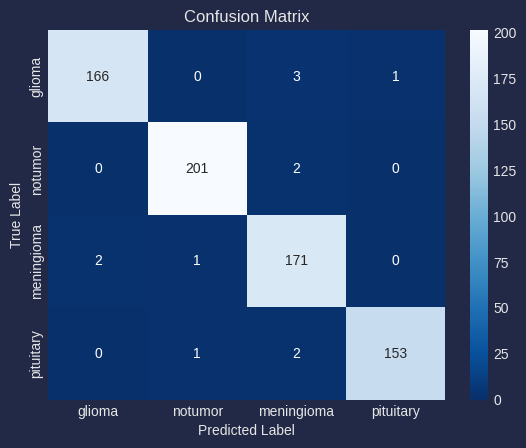

In [63]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [64]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       170
           1       0.99      0.99      0.99       203
           2       0.96      0.98      0.97       174
           3       0.99      0.98      0.99       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



### ROC Curve

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


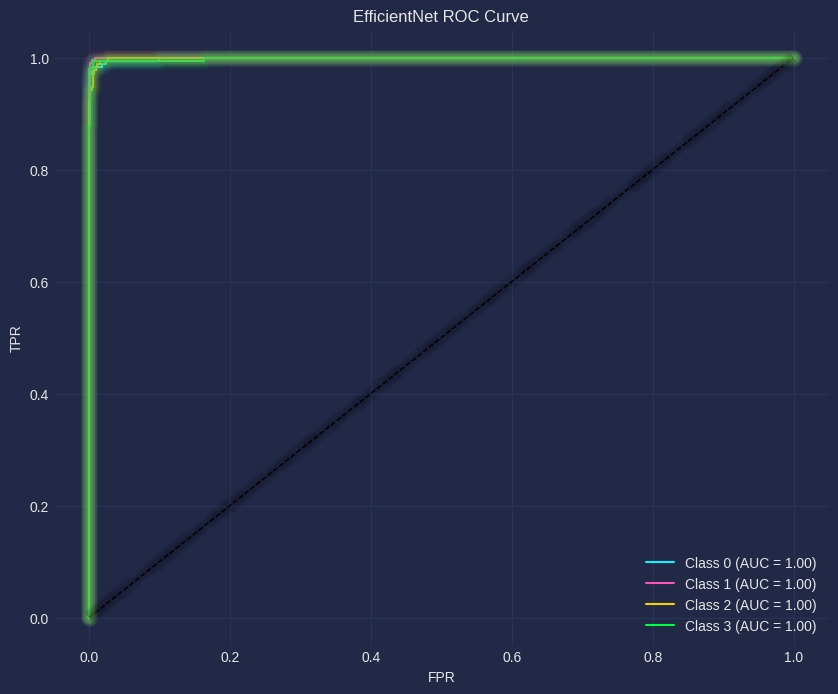

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("EfficientNet ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


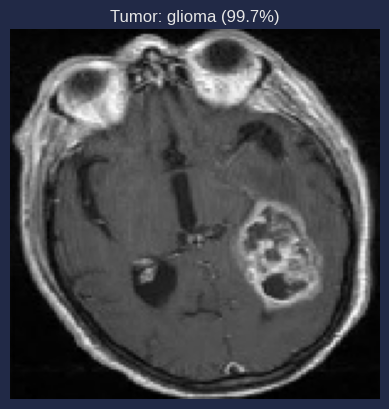

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


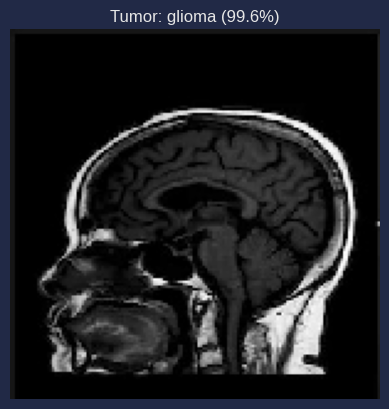

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


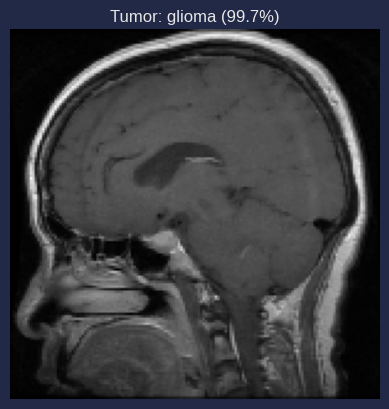

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


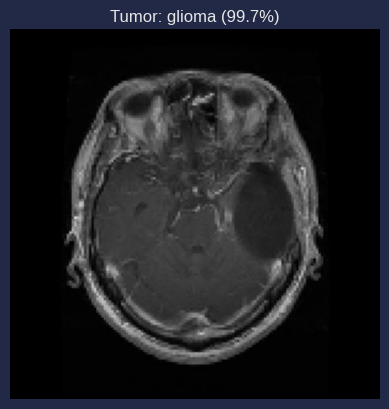

In [66]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/efficientnet_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=150):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Precision Recall Curves

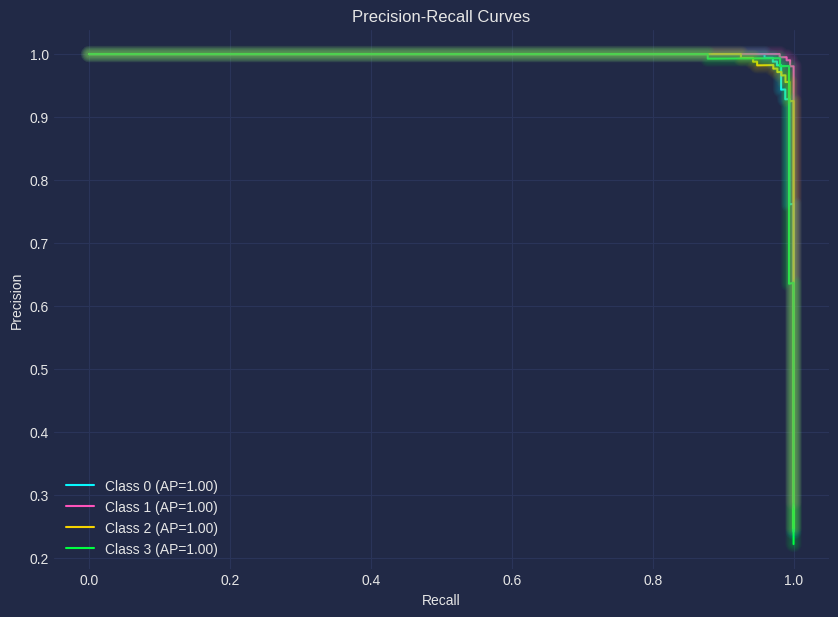

In [67]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [68]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()